# Genetic Algorithm for Traveling Salesman Problem (TSP)

https://github.com/wurmen/Genetic-Algorithm-for-Job-Shop-Scheduling-and-NSGA-II/blob/master/introduction/GA/GA.md

- Population Size： 一個族群中染色體的數量
- Chromosomes：染色體，代表路徑解
- Crossover：兩個染色體繁衍出具有共同點子代的過程，從路徑中取出一段路徑插入到另一個路徑中
- Mutation：突變也是演化當中很重要的一環，透過隨機替換染色體我們有可能得到更好的子代
- Selection：透過一些選擇機制，將品質較好的染色體留下來，形成新的 Population

In [1]:
import random as rd
import numpy as np
import pandas as pd
import time

In [2]:
NUM_NODES = 20
MAX_X = 100
MAX_Y = 100
NUM_VEHICLES = 1
NUM_DEPOT = 0

POPULATION_SIZE = 10 # 由於基因兩兩成對的性質，群體必須為二的次方，否則無法進行交配
CROSSOVER_RATE = 0.5
MUTATION_RATE = 0.5
NUM_ITERATIONS = 1000

In [12]:
def create_data_model():
    data = {}
    data['num_locations'] = [(rd.randint(1, MAX_X), rd.randint(1, MAX_Y)) for i in range(NUM_NODES)]
    data["distance_matrix"] = compute_manhattan_distance_matrix(data['num_locations'])
    data["num_vehicles"] = NUM_VEHICLES
    data["depot"] = NUM_DEPOT
    return data

def compute_manhattan_distance_matrix(nodes):
    distance_matrix = []
    for node_i in nodes:
        distances = []
        for node_j in nodes:
            if node_i == node_j:
                distances.append(0)
            else:
                manhattan_distance = np.sum(np.abs(np.array(node_i) - np.array(node_j)))
                distances.append(manhattan_distance)
        distance_matrix.append(distances)
    return distance_matrix

def create_result_model():
    '''
    [儲存實驗結果]
    迭代次數, 交配次數, 突變次數, 執行時間, 路徑, 最佳路徑, 最短距離
    '''
    result = {}
    result['iteration'] = []
    result['num_crossover'] = []
    result['num_mutation'] = []
    result['duration'] = []
    result['routes'] = []
    result['shortest_route'] = []
    result['shortest_distance'] = []   
    return result

data = create_data_model()

print("data['num_locations']:", data['num_locations'])
print("data['distance_matrix']:", data['distance_matrix'])

data['num_locations']: [(97, 13), (73, 68), (99, 80), (67, 13), (39, 75), (29, 7), (58, 10), (69, 11), (42, 79), (23, 61), (99, 18), (22, 40), (77, 62), (42, 5), (32, 66), (99, 20), (76, 31), (44, 94), (28, 52), (46, 87)]
data['distance_matrix']: [[0, 79, 69, 30, 120, 74, 42, 30, 121, 122, 7, 102, 69, 63, 118, 9, 39, 134, 108, 125], [79, 0, 38, 61, 41, 105, 73, 61, 42, 57, 76, 79, 10, 94, 43, 74, 40, 55, 61, 46], [69, 38, 0, 99, 65, 143, 111, 99, 58, 95, 62, 117, 40, 132, 81, 60, 72, 69, 99, 60], [30, 61, 99, 0, 90, 44, 12, 4, 91, 92, 37, 72, 59, 33, 88, 39, 27, 104, 78, 95], [120, 41, 65, 90, 0, 78, 84, 94, 7, 30, 117, 52, 51, 73, 16, 115, 81, 24, 34, 19], [74, 105, 143, 44, 78, 0, 32, 44, 85, 60, 81, 40, 103, 15, 62, 83, 71, 102, 46, 97], [42, 73, 111, 12, 84, 32, 0, 12, 85, 86, 49, 66, 71, 21, 82, 51, 39, 98, 72, 89], [30, 61, 99, 4, 94, 44, 12, 0, 95, 96, 37, 76, 59, 33, 92, 39, 27, 108, 82, 99], [121, 42, 58, 91, 7, 85, 85, 95, 0, 37, 118, 59, 52, 74, 23, 116, 82, 17, 41, 12], [12

### Genetic Algorithm

In [32]:
def do_greedy_algorithm_for_TSP(start_index):

    import copy

    route = [start_index]
    distances = copy.deepcopy(data["distance_matrix"])

    def do_iteration(node_index):
        if len(route) == (len(distances) - 1):
            route.append(0)
            return
        else:
            distances[node_index][0] = 999999 # node_0 的距離設為無限大，避免回到出發點
            distances[node_index][node_index] = 999999 # 自己到自己的距離設為無限大，避免不移動
            next_index = distances[node_index].index(min(distances[node_index]))
            route.append(next_index)
            for i in range(len(distances)):
                distances[i][node_index] = 999999
            return do_iteration(next_index)

    do_iteration(start_index)
    return route

# initial solution
def create_initial_solution():
    routes = []
    ''' randomly generate routes '''
    # for i in range(POPULATION_SIZE):
    #     route = [i for i in range(1, NUM_NODES)]
    #     rd.shuffle(route)
    #     route.append(0)
    #     routes.append(route)
    
    # generate route by greedy algorithm
    '''
    產生 POPULATIONS_SIZE 數量的初代
    隨機選擇 n 個點，每個點透過 Greedy 求最佳路徑
    NUM_NODES 必須大於 POPULATION_SIZE，否則會出現錯誤 (抽樣數量大於母體數量)
    '''
    if NUM_NODES < POPULATION_SIZE:
        print("Error: NUM_NODES must be greater than POPULATION_SIZE.")
        return
    indexes = rd.sample([i for i in range(1, NUM_NODES)], POPULATION_SIZE)
    for index in indexes:
        routes.append(do_greedy_algorithm_for_TSP(index))
    return routes

# fitness value
def get_objective_value(route):
    objective_value = 0
    for i in range(len(route) - 1):
        objective_value += data['distance_matrix'][route[i]][route[i + 1]]
    return objective_value

# crossover
def do_crossover(routes):

    num_crossover = 0

    for i in range(0, len(routes), 2):
    
        if i + 1 < len(routes):
            route1 = routes[i]
            route2 = routes[i + 1]
            if len(route1) == len(route2):
                prob = rd.random()
                if CROSSOVER_RATE > prob:
                    # print("Crossover!", "Route1:", route1, ", Route2:", route2)
                    parent1, parent2 = route1.copy(), route2.copy()            
                    interval = rd.sample([i for i in range(0, len(parent1) - 2)], 2) # 隨機決定交配的基因片段起始位置
                    start, end = min(interval), max(interval)

                    genes1 = parent1[start:end] # 取得要進行交配的基因片段
                    offspring1 = [i for i in parent2 if i not in genes1] # 將 parent2 中重複的基因片段移除, 其餘遺傳給子代 offspring1
                    index = rd.randint(0, len(offspring1) - 1) # 隨機決定插入基因片段的位置索引值, 
                    offspring1[index:index] = genes1 # 將基因片段插入子代中

                    genes2 = parent2[start:end]
                    offspring2 = [i for i in parent1 if i not in genes2]
                    offspring2[index:index] = genes2

                    routes += [offspring1, offspring2]
                    num_crossover += 1
            else:
                print("Error: The length of two chromosome are not equal.")

    return routes, num_crossover

# mutation
def do_mutation(routes):

    num_mutation = 0

    for i in range(len(routes)):

        route = routes[i] 
        chromosome = route.copy()
        prob = rd.random()
        if MUTATION_RATE > prob:
            # print("Mutation!")
            num_mutation = rd.randint(1, len(chromosome)-1) # 隨機決定突變的基因數量
            mutation_indexes = rd.sample([i for i in range(0, len(chromosome)-1)], num_mutation) # 隨機決定突變的基因位置
            mutation_genes = [chromosome[i] for i in mutation_indexes] # 取得突變的基因
            rd.shuffle(mutation_genes) # 突變開始, 隨機排序基因
            for index, i in enumerate(mutation_indexes): # 依序將突變後的基因放回染色體
                chromosome[i] = mutation_genes[index]
                routes += [chromosome]
                num_mutation += 1
    
    return routes, num_mutation

# selection (Tournament selection)
# 取群體中路徑長度(fitness value)前 {POPULATION_SIZE} 筆資料，進入到下一次迭代
def do_selection(chromosomes):
    # 移除重複的染色體, 轉換成 set 再轉回 list
    chromosomes = list(set([tuple(chromosome) for chromosome in chromosomes]))
    chromosomes = [list(chromosome) for chromosome in chromosomes]
    if len(chromosomes) < POPULATION_SIZE:
        print(f'Chromosomes is less than {POPULATION_SIZE}. Regenerate chromosomes...')
        chromosomes += create_initial_solution()
        do_selection(chromosomes)
    # print('Selection!')
    # print('Length of chromosomes:', len(chromosomes))
    chromosomes.sort(key=lambda x: get_objective_value(x))
    # print('Best chromosome', chromosomes[0], ', Objective value:', get_objective_value(chromosomes[0]))
    return chromosomes[:POPULATION_SIZE]

def print_solution(data, routes):
    routes = [list(routes[0])]
    for vehicle_id in range(data["num_vehicles"]):
        index = 0
        plan_output = f"Route for vehicle {vehicle_id}:\n0 -> "
        route_distance = get_objective_value(routes[vehicle_id])
        while index < len(routes[vehicle_id]) - 1:
            plan_output += f" {routes[vehicle_id][index]} -> "
            index += 1
        plan_output += f"0\nDistance of the route: {route_distance} m\n"
        print(plan_output)

In [33]:
def main():

    result = create_result_model() # 儲存每次迭代的結果

    routes = do_selection(create_initial_solution())
    print("Initial Solution:", routes, "\n")
    iteration = 0

    while NUM_ITERATIONS > iteration:

        start_time = time.time()

        routes, num_crossover = do_crossover(routes) # crossover
        routes, num_mutation = do_mutation(routes) # mutation
        routes = do_selection(routes) # selection

        end_time = time.time()
        iteration += 1
        # print("Iteration:", iteration, "Solution:", routes, "\n")

        output = {
            'iteration': iteration, 
            'num_crossover': num_crossover, 
            'num_mutation': num_mutation, 
            'duration': round(end_time - start_time, 5), 
            'routes': routes, 
            'shortest_route': routes[0], 
            'shortest_distance': get_objective_value(routes[0])
        }
              
        for key in result:
            result[key].append(output[key])

    fitness_values = [get_objective_value(route) for route in routes]
    # print("Final Solution:", routes)
    return [routes[fitness_values.index(min(fitness_values))]], result

routes, result = main()
print_solution(data ,routes)

Initial Solution: [[17, 19, 8, 4, 14, 9, 18, 11, 5, 13, 6, 3, 7, 16, 12, 1, 2, 15, 10, 0], [4, 8, 19, 17, 14, 9, 18, 11, 5, 13, 6, 3, 7, 16, 12, 1, 2, 15, 10, 0], [16, 3, 7, 6, 13, 5, 11, 18, 9, 14, 4, 8, 19, 17, 1, 12, 2, 15, 10, 0], [10, 15, 16, 3, 7, 6, 13, 5, 11, 18, 9, 14, 4, 8, 19, 17, 1, 12, 2, 0], [2, 1, 12, 16, 3, 7, 6, 13, 5, 11, 18, 9, 14, 4, 8, 19, 17, 15, 10, 0], [7, 3, 6, 13, 5, 11, 18, 9, 14, 4, 8, 19, 17, 1, 12, 16, 15, 10, 2, 0], [14, 9, 18, 11, 5, 13, 6, 3, 7, 16, 12, 1, 2, 8, 4, 19, 17, 15, 10, 0], [5, 13, 6, 3, 7, 16, 12, 1, 2, 8, 4, 14, 9, 18, 11, 19, 17, 15, 10, 0], [18, 9, 14, 4, 8, 19, 17, 1, 12, 16, 3, 7, 6, 13, 5, 11, 15, 10, 2, 0], [12, 1, 2, 8, 4, 14, 9, 18, 11, 5, 13, 6, 3, 7, 16, 15, 10, 19, 17, 0]] 

Route for vehicle 0:
0 ->  17 ->  19 ->  8 ->  4 ->  14 ->  9 ->  18 ->  11 ->  5 ->  13 ->  6 ->  7 ->  3 ->  16 ->  12 ->  1 ->  2 ->  15 ->  10 -> 0
Distance of the route: 358 m



In [34]:
pd.DataFrame(result).head(10)

,iteration,num_crossover,num_mutation,duration,routes,shortest_route,shortest_distance
0,1,3,28,0.00027,"[[17, 19, 8, 4, 14, 9, 18, 11, 5, 13, 6, 3, 7,...","[17, 19, 8, 4, 14, 9, 18, 11, 5, 13, 6, 3, 7, ...",358
1,2,1,10,0.00018,"[[17, 19, 8, 4, 14, 9, 18, 11, 5, 13, 6, 3, 7,...","[17, 19, 8, 4, 14, 9, 18, 11, 5, 13, 6, 3, 7, ...",358
2,3,4,34,0.00038,"[[17, 19, 8, 4, 14, 9, 18, 11, 5, 13, 6, 3, 7,...","[17, 19, 8, 4, 14, 9, 18, 11, 5, 13, 6, 3, 7, ...",358
3,4,2,16,0.00025,"[[17, 19, 8, 4, 14, 9, 18, 11, 5, 13, 6, 3, 7,...","[17, 19, 8, 4, 14, 9, 18, 11, 5, 13, 6, 3, 7, ...",358
4,5,2,32,0.00031,"[[17, 19, 8, 4, 14, 9, 18, 11, 5, 13, 6, 3, 7,...","[17, 19, 8, 4, 14, 9, 18, 11, 5, 13, 6, 3, 7, ...",358
5,6,4,18,0.00029,"[[17, 19, 8, 4, 14, 9, 18, 11, 5, 13, 6, 3, 7,...","[17, 19, 8, 4, 14, 9, 18, 11, 5, 13, 6, 3, 7, ...",358
6,7,2,14,0.00023,"[[17, 19, 8, 4, 14, 9, 18, 11, 5, 13, 6, 3, 7,...","[17, 19, 8, 4, 14, 9, 18, 11, 5, 13, 6, 3, 7, ...",358
7,8,1,2,0.00019,"[[17, 19, 8, 4, 14, 9, 18, 11, 5, 13, 6, 3, 7,...","[17, 19, 8, 4, 14, 9, 18, 11, 5, 13, 6, 3, 7, ...",358
8,9,4,30,0.00052,"[[17, 19, 8, 4, 14, 9, 18, 11, 5, 13, 6, 3, 7,...","[17, 19, 8, 4, 14, 9, 18, 11, 5, 13, 6, 3, 7, ...",358
9,10,2,24,0.00038,"[[17, 19, 8, 4, 14, 9, 18, 11, 5, 13, 6, 3, 7,...","[17, 19, 8, 4, 14, 9, 18, 11, 5, 13, 6, 3, 7, ...",358


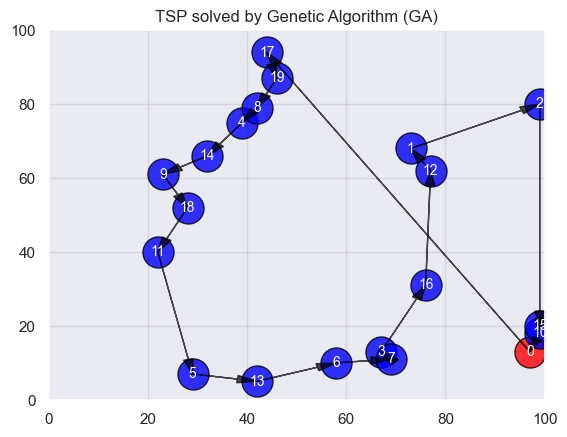

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_map():
    sns.set()
    plt.title('TSP solved by Genetic Algorithm (GA)')
    plt.grid(color='gray', linestyle='-', linewidth=1, alpha=0.2)
    plt.xlim(0, MAX_X)
    plt.ylim(0, MAX_X)

    plotted_routes = routes.copy()
    for index, route in enumerate(plotted_routes):
        plotted_routes[index][0:0] = [0]

    # Draw nodes
    for index, node in enumerate(data['num_locations']):

        node_kwargs = dict(s=500, color='blue', alpha=0.8, edgecolors='black')

        if index == 0:
            node_kwargs['color'] = 'red'

        plt.scatter(x=node[0], y=node[1], **node_kwargs)
        plt.text(x=node[0], y=node[1], s=str(index), fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')
    
    # Draw lines
    for route in plotted_routes: 
        arrow_kwargs = dict(length_includes_head=True, head_width=2, head_length=4, color='black', alpha=0.7)

        for index, node in enumerate(route):
            start_loc = data['num_locations'][route[index]]
            end_loc = data['num_locations'][route[index + 1]] if index < (len(route) - 1) else data['num_locations'][route[-1]]
            plt.arrow(x=start_loc[0], y=start_loc[1], dx=(end_loc[0] - start_loc[0]), dy=(end_loc[1] - start_loc[1]), **arrow_kwargs)
    
    return

plot_map()